In [3]:
import os
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

Data Extraction and Loading Functions

In [4]:
def extract_dataset(archive_path, extract_to="./data"):
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=extract_to)
        
extract_dataset("cifar-10-python.tar.gz")


In [5]:
def load_cifar_batch(batch_file):
    with open(batch_file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        images = dict[b'data']
        labels = dict[b'labels']
    images = images.reshape(-1, 3, 32, 32).astype("uint8")
    return images, labels

def load_training_batches(folder="data/cifar-10-batches-py"):
    images_all, labels_all = [], []
    for i in range(1, 6):
        file_path = os.path.join(folder, f"data_batch_{i}")
        imgs, lbls = load_cifar_batch(file_path)
        images_all.append(imgs)
        labels_all.extend(lbls)
    images_all = np.concatenate(images_all)
    labels_all = np.array(labels_all)
    return images_all, labels_all

def load_test_batch(folder="data/cifar-10-batches-py"):
    file_path = os.path.join(folder, "test_batch")
    return load_cifar_batch(file_path)


Visualizing CIFAR-10 Images with Labels



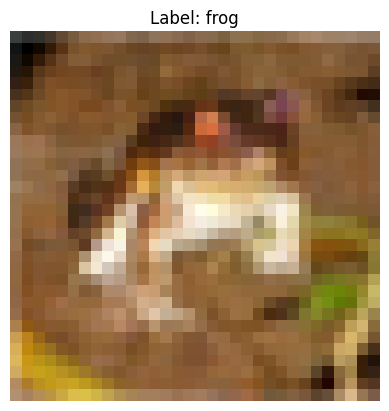

In [6]:
def show_image(img_array, label=None):
    img = np.transpose(img_array, (1, 2, 0))
    plt.imshow(img)
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

sample_imgs, sample_labels = load_cifar_batch("data/cifar-10-batches-py/data_batch_1")
show_image(sample_imgs[0], cifar10_classes[sample_labels[0]])


Dataset Preparation, Augmentation, and DataLoader Setup



In [7]:
train_images, train_labels = load_training_batches()
test_images, test_labels = load_test_batch()

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels
)

X_test, y_test = test_images, test_labels


In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

transform_eval = transforms.Compose([
    transforms.ToTensor()
])

class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    # Convert from [C, H, W] NumPy to [H, W, C] for PIL compatibility
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))
        # Apply transformations (augmentation or normalization)
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

train_loader = DataLoader(CIFARDataset(X_train, y_train, transform_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(CIFARDataset(X_val, y_val, transform_eval), batch_size=64, shuffle=False)
test_loader  = DataLoader(CIFARDataset(X_test, y_test, transform_eval), batch_size=64, shuffle=False)


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Training and Evaluation Functions with Model Initialization

In [10]:
def evaluate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return val_loss, acc, f1



In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    history = {"train_loss": [], "train_acc": [], "train_f1": [],
               "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        y_true, y_pred = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(acc)
        history["train_f1"].append(f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")
        print(f"→ Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    
    return history


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
from torch.optim import Adam, SGD
import pandas as pd

# Grid of hyperparameter configurations
configurations = [
    {"batch_size": 32, "lr": 0.001, "optimizer": "adam"},
    {"batch_size": 64, "lr": 0.001, "optimizer": "adam"},
    {"batch_size": 32, "lr": 0.0005, "optimizer": "sgd"},
    {"batch_size": 64, "lr": 0.0005, "optimizer": "sgd"},
]

# Store results for comparison
results = []

# Select optimizer based on name
def get_optimizer(name, parameters, lr):
    if name == "adam":
        return Adam(parameters, lr=lr)
    elif name == "sgd":
        return SGD(parameters, lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")

# Loop over each configuration
for config in configurations:
    print(f"Training with config: {config}")
    
    train_loader = DataLoader(CIFARDataset(X_train, y_train, transform_train), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(CIFARDataset(X_val, y_val, transform_eval), batch_size=config["batch_size"], shuffle=False)

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"])

    history = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

    # Extract last validation metrics
    val_acc = history["val_acc"][-1]
    val_f1 = history["val_f1"][-1]

    results.append({
        "batch_size": config["batch_size"],
        "lr": config["lr"],
        "optimizer": config["optimizer"],
        "val_acc": val_acc,
        "val_f1": val_f1
    })


Training with config: {'batch_size': 32, 'lr': 0.001, 'optimizer': 'adam'}
Epoch 1 | Train Loss: 2099.3305 | Acc: 0.3855 | F1: 0.3783
→ Val Loss: 455.1953 | Acc: 0.4698 | F1: 0.4580
Epoch 2 | Train Loss: 1753.1303 | Acc: 0.4935 | F1: 0.4889
→ Val Loss: 386.4741 | Acc: 0.5506 | F1: 0.5490
Epoch 3 | Train Loss: 1599.8534 | Acc: 0.5417 | F1: 0.5382
→ Val Loss: 361.0437 | Acc: 0.5828 | F1: 0.5802
Epoch 4 | Train Loss: 1501.6234 | Acc: 0.5733 | F1: 0.5702
→ Val Loss: 337.8134 | Acc: 0.6203 | F1: 0.6154
Epoch 5 | Train Loss: 1419.5824 | Acc: 0.5956 | F1: 0.5928
→ Val Loss: 313.9315 | Acc: 0.6428 | F1: 0.6394
Epoch 6 | Train Loss: 1365.1634 | Acc: 0.6101 | F1: 0.6077
→ Val Loss: 298.6651 | Acc: 0.6647 | F1: 0.6609
Epoch 7 | Train Loss: 1318.9001 | Acc: 0.6281 | F1: 0.6257
→ Val Loss: 302.9326 | Acc: 0.6567 | F1: 0.6507
Epoch 8 | Train Loss: 1288.4488 | Acc: 0.6354 | F1: 0.6333
→ Val Loss: 291.6964 | Acc: 0.6713 | F1: 0.6663
Epoch 9 | Train Loss: 1261.1436 | Acc: 0.6433 | F1: 0.6414
→ Val Loss

Visualizing Training and Validation Metrics per Epoch



In [14]:
results_df = pd.DataFrame(results)
print("All results:")
print(results_df)

# Find the configuration with the highest validation accuracy
best_idx = results_df["val_acc"].idxmax()
best_config = results_df.loc[best_idx]

print("Best configuration:")
print(best_config)


All results:
   batch_size      lr optimizer  val_acc    val_f1
0          32  0.0010      adam   0.7472  0.747484
1          64  0.0010      adam   0.7422  0.737441
2          32  0.0005       sgd   0.6388  0.634602
3          64  0.0005       sgd   0.5543  0.552324
Best configuration:
batch_size          32
lr               0.001
optimizer         adam
val_acc         0.7472
val_f1        0.747484
Name: 0, dtype: object


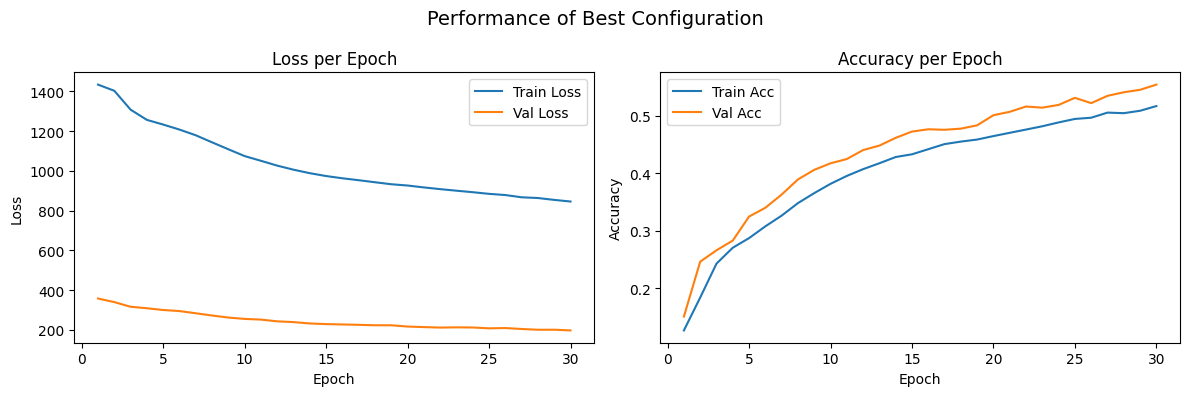

In [15]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.suptitle("Performance of Best Configuration", fontsize=14)
plt.tight_layout()
plt.show()


Saving the Trained Model and Evaluating on the Test Set


In [16]:
best_model = SimpleCNN().to(device)
best_optimizer = get_optimizer(best_config["optimizer"], best_model.parameters(), best_config["lr"])

train_loader_best = DataLoader(CIFARDataset(X_train, y_train, transform_train), batch_size=int(best_config["batch_size"]), shuffle=True)
val_loader_best   = DataLoader(CIFARDataset(X_val, y_val, transform_eval), batch_size=int(best_config["batch_size"]), shuffle=False)

print("Retraining best model for saving and testing...")
best_history = train(best_model, train_loader_best, val_loader_best, criterion, best_optimizer, device, num_epochs=30)

Retraining best model for saving and testing...
Epoch 1 | Train Loss: 2061.2403 | Acc: 0.3965 | F1: 0.3907
→ Val Loss: 466.8183 | Acc: 0.4522 | F1: 0.4365
Epoch 2 | Train Loss: 1691.6028 | Acc: 0.5132 | F1: 0.5090
→ Val Loss: 364.6101 | Acc: 0.5807 | F1: 0.5791
Epoch 3 | Train Loss: 1545.5132 | Acc: 0.5569 | F1: 0.5532
→ Val Loss: 342.8773 | Acc: 0.6065 | F1: 0.6064
Epoch 4 | Train Loss: 1454.7569 | Acc: 0.5854 | F1: 0.5825
→ Val Loss: 318.4641 | Acc: 0.6387 | F1: 0.6296
Epoch 5 | Train Loss: 1386.7303 | Acc: 0.6019 | F1: 0.5995
→ Val Loss: 306.7770 | Acc: 0.6501 | F1: 0.6469
Epoch 6 | Train Loss: 1344.9871 | Acc: 0.6200 | F1: 0.6181
→ Val Loss: 307.2990 | Acc: 0.6597 | F1: 0.6600
Epoch 7 | Train Loss: 1302.5642 | Acc: 0.6313 | F1: 0.6292
→ Val Loss: 305.9092 | Acc: 0.6526 | F1: 0.6493
Epoch 8 | Train Loss: 1266.9355 | Acc: 0.6431 | F1: 0.6413
→ Val Loss: 279.0764 | Acc: 0.6795 | F1: 0.6779
Epoch 9 | Train Loss: 1236.0911 | Acc: 0.6528 | F1: 0.6513
→ Val Loss: 271.0268 | Acc: 0.6928 | 

In [17]:
torch.save(best_model.state_dict(), "best_model_cnn.pth")
print("Best model saved to best_model_cnn.pth")

Best model saved to best_model_cnn.pth


In [18]:
test_loss, test_acc, test_f1 = evaluate(best_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}")

Test Accuracy: 0.7451 | Test F1: 0.7443
